In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

import shutil
from random import shuffle

import librosa
import librosa.display


import torch
from torch import nn
from torchvision import models, transforms, datasets

from time import time
from tqdm import tqdm

In [13]:
seed = 42
np.random.seed(seed)

path = "../Data"
path_audio_files = path + "/genres_original/"
path_imgs = "../Data/images_original/"
batch_size = 32
hop_length = 512
n_fft = 2048
device = 'cuda' if torch.cuda.is_available() else 'cpu'

genre_dict = {"blues":0,"classical":1,"country":2,"disco":3,"hiphop":4,"jazz":5,"metal":6,"pop":7,"reggae":8,"rock":9}

In [ ]:
print("Transforming the Audio Files into Mel Spectrograms:")

mel_spectogram_data = {}
for genre in genre_dict.keys():
    print("\t",genre)
    
    mel_spectogram_data[genre] = []

    for name in glob.glob(path_audio_files + genre + "/*"):
        if(name != "../Data/genres_original/jazz/jazz.00054.wav"):
        
            data,sampling_rate = librosa.load(name)

            mel_spec = librosa.feature.melspectrogram(y = data.ravel(), sr=sampling_rate,hop_length = hop_length)
            mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)

            mel_spectogram_data[genre].append(mel_spec_db)
            

print("Saving the Mel Spectrogram Images:")
            
os.mkdir(path_imgs)
for genre in genre_dict.keys():
    print("\t",genre)
    try:
        os.mkdir(path_imgs + genre)
    except:
        pass
    for i in range(len(mel_spectogram_data[genre])):
        fig, ax = plt.subplots(1, figsize=(12,8))
        img = librosa.display.specshow(mel_spectogram_data[genre][i], sr = sampling_rate, hop_length = hop_length,cmap = 'cool',ax=ax)
        fig.savefig(path_imgs + genre + "/" + genre + "_" + str(i) + ".png")
        plt.close()

In [14]:
import gc
gc.collect()

1727

In [17]:
import torch
from torchvision import datasets, transforms

# Define Transforms
train_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

test_transforms = transforms.Compose([
    #transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4931, 0.9151, 0.9960], std=[0.4495, 0.1716, 0.0602])
])

# Paths to the train, validation, and test folders
train_path = '../Data/train/images_original'  # Update this path
val_path = '../Data/val/images_original'      # Update this path
test_path = '../Data/test/images_original'    # Update this path

# Load the data from folders
train_dataset = datasets.ImageFolder(train_path, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_path, transform=test_transforms)
test_dataset = datasets.ImageFolder(test_path, transform=test_transforms)

# Batch Size (Define it if not already defined)
batch_size = 32  # Update this as per your requirement

# Make DataLoaders
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Classes
classes = train_dataset.classes
print(f"Classes: {classes}")

# Print the number of samples in each set
print(f"Number of Train Samples: {len(train_dataset)}")
print(f"Number of Validation Samples: {len(val_dataset)}")
print(f"Number of Test Samples: {len(test_dataset)}")


Classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Number of Train Samples: 800
Number of Validation Samples: 100
Number of Test Samples: 99


In [18]:
def mean_std(loader):
    images, lebels = next(iter(loader))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

mean, std = mean_std(train_dataloader)
print("mean and std: \n", mean, std)

mean and std: 
 tensor([ 0.0274, -2.7448, -7.9663]) tensor([1.0179, 2.7438, 7.1918])


### Resnet18 Transfer Learning

In [19]:
# Load a Pretrained Model
resnet = models.resnet18(pretrained=True)

# Fix the trainable parameters
for parameter in resnet.parameters():
    parameter.requires_grad = False
    
    
# Number of Input Features in the Last Fully Connected Layer
in_features = resnet.fc.in_features

# Replacing the Last Fully Connected Layer
fc = nn.Linear(in_features=in_features, out_features=len(classes))
resnet.fc = fc


# Updating the Weights and Bias of the last layer
params_to_update = []
for name, param in resnet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

# Define the Loss and Optimizer Functions
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.001)

/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sanyam/anaconda3/envs/MGC/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, print_every, num_epoch, save_at_epoch, checkpoint_path=None):

    steps = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    start_epoch = 0

    model.to(device)

    # Load checkpoint if provided
    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        train_accuracies = checkpoint.get('train_accuracies', [])
        val_accuracies = checkpoint.get('val_accuracies', [])

    for epoch in tqdm(range(start_epoch, num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()

        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
        
        train_accuracy = correct_train / total_train * 100
        train_accuracies.append(train_accuracy)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        correct_val, total_val = 0, 0
        val_loss = 0

        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                output = model(images)
                loss = criterion(output, labels)
                val_loss += loss.item()
                
                correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                total_val += labels.size(0)

        # Validation Accuracy
        val_accuracy = correct_val / total_val * 100
        val_accuracies.append(val_accuracy)

        # Validation Loss
        val_loss = val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f'Val loss {val_loss:.3f}.', end=' ')
        print(f'Val acc {val_accuracy:.3f}.', end=' ')
        print(f'Took {time() - iter_time:.3f} seconds')
        iter_time = time()
        
        print(f'Epoch took {time() - start_time}')
        # Save checkpoint

        if epoch % save_at_epoch == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }
            torch.save(checkpoint, f'../Models/Resnet18/checkpoint_{epoch}.pth')

    return model, train_losses, val_losses, train_accuracies, val_accuracies


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1]/[50]. Batch [25]/[25]. Train loss 0.622. Train acc 83.250. 

  2%|▏         | 1/50 [00:36<29:24, 36.02s/it]

Val loss 1.169. Val acc 69.000. Took 35.871 seconds
Epoch took 35.871312618255615
Epoch [2]/[50]. Batch [25]/[25]. Train loss 0.297. Train acc 85.625. 

  4%|▍         | 2/50 [01:13<29:42, 37.14s/it]

Val loss 1.170. Val acc 70.000. Took 37.926 seconds
Epoch took 37.92587924003601
Epoch [3]/[50]. Batch [25]/[25]. Train loss 0.213. Train acc 82.625. 

  6%|▌         | 3/50 [01:48<28:18, 36.14s/it]

Val loss 1.211. Val acc 69.000. Took 34.956 seconds
Epoch took 34.95608329772949
Epoch [4]/[50]. Batch [25]/[25]. Train loss 0.154. Train acc 83.375. 

  8%|▊         | 4/50 [02:21<26:42, 34.83s/it]

Val loss 1.356. Val acc 67.000. Took 32.825 seconds
Epoch took 32.82548785209656
Epoch [5]/[50]. Batch [25]/[25]. Train loss 0.116. Train acc 85.125. 

 10%|█         | 5/50 [02:54<25:34, 34.10s/it]

Val loss 1.201. Val acc 70.000. Took 32.809 seconds
Epoch took 32.809202909469604
Epoch [6]/[50]. Batch [25]/[25]. Train loss 0.100. Train acc 84.500. 

 12%|█▏        | 6/50 [03:27<24:41, 33.66s/it]

Val loss 1.217. Val acc 68.000. Took 32.798 seconds
Epoch took 32.79752779006958
Epoch [7]/[50]. Batch [25]/[25]. Train loss 0.085. Train acc 85.250. 

 14%|█▍        | 7/50 [04:00<23:55, 33.39s/it]

Val loss 1.198. Val acc 69.000. Took 32.839 seconds
Epoch took 32.83854794502258
Epoch [8]/[50]. Batch [25]/[25]. Train loss 0.071. Train acc 85.625. 

 16%|█▌        | 8/50 [04:33<23:16, 33.24s/it]

Val loss 1.177. Val acc 70.000. Took 32.919 seconds
Epoch took 32.918662548065186
Epoch [9]/[50]. Batch [25]/[25]. Train loss 0.063. Train acc 86.125. 

 18%|█▊        | 9/50 [05:05<22:37, 33.10s/it]

Val loss 1.263. Val acc 69.000. Took 32.795 seconds
Epoch took 32.79536008834839
Epoch [10]/[50]. Batch [25]/[25]. Train loss 0.057. Train acc 84.500. 

 20%|██        | 10/50 [05:38<22:01, 33.03s/it]

Val loss 1.204. Val acc 66.000. Took 32.878 seconds
Epoch took 32.87841987609863
Epoch [11]/[50]. Batch [25]/[25]. Train loss 0.051. Train acc 85.000. 

 22%|██▏       | 11/50 [06:11<21:29, 33.07s/it]

Val loss 1.219. Val acc 69.000. Took 33.003 seconds
Epoch took 33.00304961204529
Epoch [12]/[50]. Batch [25]/[25]. Train loss 0.048. Train acc 85.500. 

 24%|██▍       | 12/50 [06:44<20:48, 32.86s/it]

Val loss 1.338. Val acc 69.000. Took 32.392 seconds
Epoch took 32.39221262931824
Epoch [13]/[50]. Batch [25]/[25]. Train loss 0.043. Train acc 86.000. 

 26%|██▌       | 13/50 [07:16<20:07, 32.63s/it]

Val loss 1.288. Val acc 64.000. Took 32.092 seconds
Epoch took 32.09151029586792
Epoch [14]/[50]. Batch [25]/[25]. Train loss 0.041. Train acc 84.875. 

 28%|██▊       | 14/50 [07:49<19:35, 32.66s/it]

Val loss 1.202. Val acc 66.000. Took 32.736 seconds
Epoch took 32.735875606536865
Epoch [15]/[50]. Batch [25]/[25]. Train loss 0.037. Train acc 85.750. 

 30%|███       | 15/50 [08:22<19:07, 32.77s/it]

Val loss 1.218. Val acc 71.000. Took 33.031 seconds
Epoch took 33.03097987174988
Epoch [16]/[50]. Batch [25]/[25]. Train loss 0.034. Train acc 85.000. 

 32%|███▏      | 16/50 [08:54<18:30, 32.66s/it]

Val loss 1.254. Val acc 69.000. Took 32.395 seconds
Epoch took 32.394829511642456
Epoch [17]/[50]. Batch [25]/[25]. Train loss 0.031. Train acc 86.625. 

 34%|███▍      | 17/50 [09:26<17:54, 32.57s/it]

Val loss 1.191. Val acc 68.000. Took 32.365 seconds
Epoch took 32.36486840248108
Epoch [18]/[50]. Batch [25]/[25]. Train loss 0.030. Train acc 85.500. 

 36%|███▌      | 18/50 [09:59<17:19, 32.47s/it]

Val loss 1.253. Val acc 69.000. Took 32.235 seconds
Epoch took 32.234636545181274
Epoch [19]/[50]. Batch [25]/[25]. Train loss 0.027. Train acc 86.875. 

 38%|███▊      | 19/50 [10:31<16:44, 32.41s/it]

Val loss 1.195. Val acc 69.000. Took 32.253 seconds
Epoch took 32.25330591201782
Epoch [20]/[50]. Batch [25]/[25]. Train loss 0.026. Train acc 87.250. 

 40%|████      | 20/50 [11:04<16:18, 32.61s/it]

Val loss 1.243. Val acc 70.000. Took 33.100 seconds
Epoch took 33.099631547927856
Epoch [21]/[50]. Batch [25]/[25]. Train loss 0.025. Train acc 86.750. 

 42%|████▏     | 21/50 [11:37<15:51, 32.80s/it]

Val loss 1.264. Val acc 70.000. Took 33.131 seconds
Epoch took 33.13069725036621
Epoch [22]/[50]. Batch [25]/[25]. Train loss 0.023. Train acc 87.625. 

 44%|████▍     | 22/50 [12:10<15:21, 32.91s/it]

Val loss 1.200. Val acc 68.000. Took 33.171 seconds
Epoch took 33.1708869934082
Epoch [23]/[50]. Batch [25]/[25]. Train loss 0.022. Train acc 87.375. 

 46%|████▌     | 23/50 [12:44<14:52, 33.07s/it]

Val loss 1.228. Val acc 68.000. Took 33.428 seconds
Epoch took 33.428277015686035
Epoch [24]/[50]. Batch [25]/[25]. Train loss 0.021. Train acc 87.375. 

 48%|████▊     | 24/50 [13:17<14:18, 33.00s/it]

Val loss 1.312. Val acc 69.000. Took 32.840 seconds
Epoch took 32.84040808677673
Epoch [25]/[50]. Batch [25]/[25]. Train loss 0.020. Train acc 88.000. 

 50%|█████     | 25/50 [13:49<13:42, 32.89s/it]

Val loss 1.263. Val acc 68.000. Took 32.638 seconds
Epoch took 32.63848876953125
Epoch [26]/[50]. Batch [25]/[25]. Train loss 0.019. Train acc 87.250. 

 52%|█████▏    | 26/50 [14:23<13:12, 33.02s/it]

Val loss 1.210. Val acc 69.000. Took 33.308 seconds
Epoch took 33.30835771560669
Epoch [27]/[50]. Batch [25]/[25]. Train loss 0.018. Train acc 89.500. 

 54%|█████▍    | 27/50 [14:55<12:38, 32.97s/it]

Val loss 1.221. Val acc 68.000. Took 32.849 seconds
Epoch took 32.848580837249756
Epoch [28]/[50]. Batch [25]/[25]. Train loss 0.018. Train acc 87.375. 

 56%|█████▌    | 28/50 [15:28<12:01, 32.82s/it]

Val loss 1.241. Val acc 69.000. Took 32.468 seconds
Epoch took 32.468358516693115
Epoch [29]/[50]. Batch [25]/[25]. Train loss 0.017. Train acc 87.375. 

 58%|█████▊    | 29/50 [16:00<11:26, 32.71s/it]

Val loss 1.351. Val acc 69.000. Took 32.471 seconds
Epoch took 32.471229791641235
Epoch [30]/[50]. Batch [25]/[25]. Train loss 0.017. Train acc 86.500. 

 60%|██████    | 30/50 [16:34<10:58, 32.91s/it]

Val loss 1.256. Val acc 70.000. Took 33.355 seconds
Epoch took 33.35544180870056
Epoch [31]/[50]. Batch [25]/[25]. Train loss 0.015. Train acc 89.500. 

 62%|██████▏   | 31/50 [17:07<10:26, 32.96s/it]

Val loss 1.175. Val acc 70.000. Took 32.968 seconds
Epoch took 32.968388080596924
Epoch [32]/[50]. Batch [25]/[25]. Train loss 0.015. Train acc 87.875. 

 64%|██████▍   | 32/50 [17:39<09:51, 32.84s/it]

Val loss 1.320. Val acc 70.000. Took 32.542 seconds
Epoch took 32.541874408721924
Epoch [33]/[50]. Batch [25]/[25]. Train loss 0.015. Train acc 87.500. 

 66%|██████▌   | 33/50 [18:12<09:16, 32.73s/it]

Val loss 1.338. Val acc 69.000. Took 32.474 seconds
Epoch took 32.474241733551025
Epoch [34]/[50]. Batch [25]/[25]. Train loss 0.014. Train acc 89.000. 

 68%|██████▊   | 34/50 [18:44<08:42, 32.65s/it]

Val loss 1.263. Val acc 69.000. Took 32.450 seconds
Epoch took 32.450153827667236
Epoch [35]/[50]. Batch [25]/[25]. Train loss 0.013. Train acc 89.000. 

 70%|███████   | 35/50 [19:17<08:10, 32.67s/it]

Val loss 1.229. Val acc 66.000. Took 32.718 seconds
Epoch took 32.71811556816101
Epoch [36]/[50]. Batch [25]/[25]. Train loss 0.013. Train acc 89.250. 

 72%|███████▏  | 36/50 [19:51<07:42, 33.00s/it]

Val loss 1.226. Val acc 68.000. Took 33.782 seconds
Epoch took 33.78225827217102
Epoch [37]/[50]. Batch [25]/[25]. Train loss 0.012. Train acc 89.500. 

 74%|███████▍  | 37/50 [20:24<07:10, 33.10s/it]

Val loss 1.181. Val acc 71.000. Took 33.328 seconds
Epoch took 33.32829570770264
Epoch [38]/[50]. Batch [25]/[25]. Train loss 0.012. Train acc 89.500. 

 76%|███████▌  | 38/50 [20:58<06:39, 33.30s/it]

Val loss 1.318. Val acc 66.000. Took 33.757 seconds
Epoch took 33.75652813911438
Epoch [39]/[50]. Batch [25]/[25]. Train loss 0.012. Train acc 89.250. 

 78%|███████▊  | 39/50 [21:31<06:05, 33.20s/it]

Val loss 1.186. Val acc 73.000. Took 32.977 seconds
Epoch took 32.97717905044556
Epoch [40]/[50]. Batch [25]/[25]. Train loss 0.012. Train acc 88.625. 

 80%|████████  | 40/50 [22:04<05:31, 33.17s/it]

Val loss 1.297. Val acc 72.000. Took 33.090 seconds
Epoch took 33.090031147003174
Epoch [41]/[50]. Batch [25]/[25]. Train loss 0.011. Train acc 90.125. 

 82%|████████▏ | 41/50 [22:37<04:58, 33.17s/it]

Val loss 1.242. Val acc 71.000. Took 33.061 seconds
Epoch took 33.06054139137268
Epoch [42]/[50]. Batch [25]/[25]. Train loss 0.011. Train acc 88.750. 

 84%|████████▍ | 42/50 [23:11<04:26, 33.28s/it]

Val loss 1.271. Val acc 67.000. Took 33.543 seconds
Epoch took 33.5428946018219
Epoch [43]/[50]. Batch [25]/[25]. Train loss 0.010. Train acc 89.250. 

 86%|████████▌ | 43/50 [23:45<03:54, 33.44s/it]

Val loss 1.392. Val acc 69.000. Took 33.810 seconds
Epoch took 33.80995726585388
Epoch [44]/[50]. Batch [25]/[25]. Train loss 0.010. Train acc 90.875. 

 88%|████████▊ | 44/50 [24:18<03:20, 33.40s/it]

Val loss 1.268. Val acc 69.000. Took 33.296 seconds
Epoch took 33.29646372795105
Epoch [45]/[50]. Batch [25]/[25]. Train loss 0.010. Train acc 90.875. 

 90%|█████████ | 45/50 [24:51<02:47, 33.42s/it]

Val loss 1.221. Val acc 67.000. Took 33.470 seconds
Epoch took 33.46964478492737
Epoch [46]/[50]. Batch [25]/[25]. Train loss 0.009. Train acc 91.000. 

 92%|█████████▏| 46/50 [25:25<02:13, 33.44s/it]

Val loss 1.294. Val acc 72.000. Took 33.498 seconds
Epoch took 33.49842095375061
Epoch [47]/[50]. Batch [25]/[25]. Train loss 0.010. Train acc 86.625. 

 94%|█████████▍| 47/50 [25:58<01:40, 33.41s/it]

Val loss 1.257. Val acc 68.000. Took 33.338 seconds
Epoch took 33.33763813972473
Epoch [48]/[50]. Batch [25]/[25]. Train loss 0.009. Train acc 89.250. 

 96%|█████████▌| 48/50 [26:32<01:06, 33.42s/it]

Val loss 1.223. Val acc 70.000. Took 33.433 seconds
Epoch took 33.432581663131714
Epoch [49]/[50]. Batch [25]/[25]. Train loss 0.008. Train acc 91.250. 

 98%|█████████▊| 49/50 [27:05<00:33, 33.43s/it]

Val loss 1.302. Val acc 69.000. Took 33.458 seconds
Epoch took 33.457807302474976
Epoch [50]/[50]. Batch [25]/[25]. Train loss 0.009. Train acc 89.125. 

100%|██████████| 50/50 [27:38<00:00, 33.18s/it]

Val loss 1.247. Val acc 70.000. Took 33.385 seconds
Epoch took 33.384586334228516


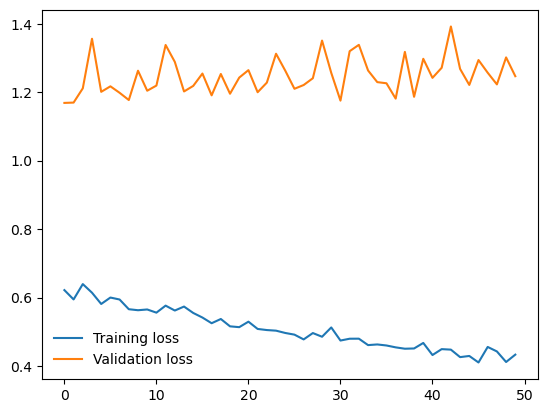

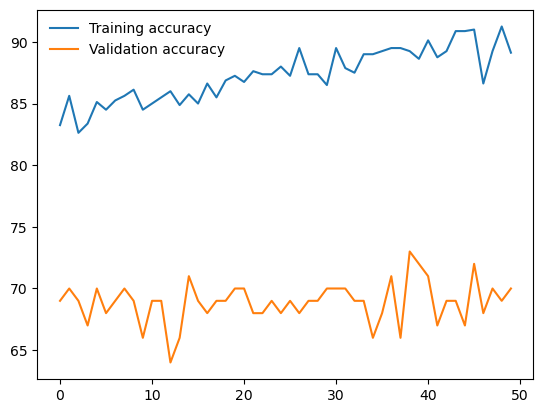

In [24]:
print_every = 25
num_epoch = 50

resnet, train_losses, val_losses, train_accuracies, val_accuracies = train(
    model=resnet,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    print_every=print_every,
    save_at_epoch=10,
    num_epoch=num_epoch
)


plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.savefig('resnet18_loss.png')
plt.show()

plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend(frameon=False)
plt.savefig('resnet18_accuracy.png')
plt.show()

In [25]:
checkpoint = {
    'epoch': 50,
    'model_state_dict': resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses
}
torch.save(checkpoint, f'../Models/Resnet18/checkpoint_{50}.pth')


### Testing

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'device' is already defined (e.g., 'cuda' or 'cpu')
# Assuming 'resnet' is your trained model
# Assuming 'genre_dict' maps indices to genre names

y_test = []
y_pred = []

# Iterate through the test dataloader
for img, label in test_dataloader:
    img = img.to(device)
    resnet.eval()
    with torch.no_grad():
        prediction = resnet(img)
    
    final_preds = torch.max(prediction, dim=1)[1]
    y_test.extend(label.tolist())
    y_pred.extend(final_preds.cpu().tolist())

# Map predicted indices back to class names
y_pred_labels = [genre_dict[pred] for pred in y_pred]

# Calculate class-wise accuracy
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
classwise_accuracy = {}

conf_matrix = confusion_matrix(y_test, y_pred)
for i in range(len(y_test)):
    label = y_test[i]
    pred = y_pred[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

for i in range(len(classes)):
    classwise_accuracy[genre_dict[i]] = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0

# Print Class-wise accuracy
for class_name, accuracy in classwise_accuracy.items():
    print(f'Accuracy of {class_name} : {accuracy:.2f} %')

# Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Accuracy:",(100*(np.array(y_test) == np.array(y_pred)).sum()/len(y_test)))

Accuracy: 62.62626262626262
